<a href="https://colab.research.google.com/github/Manash-Christ/ML-LABS/blob/main/ml_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML PROJECT - IMBALANCED CLASSIFICATION

<h2> Outline: </h2>
I. <b>Description and Preprocessing</b><br>
a) Data info and class imbalance<br>
b) Scaling and Distributing<br>
c) Splitting the Data<br>

II. <b>Random UnderSampling and Oversampling</b><br>
a) Distributing and Correlating<br>
b) Anomaly Detection<br>
c) Dimensionality Reduction and Clustering (t-SNE)<br>
d) Classifiers<br>
e) NearMiss Undersampling<br>
f) Oversampling with SMOTE<br>

III. <b>Testing </b><br>
a) Testing with Logistic Regression<br>

In [2]:
#DATA PROCESSING LIBS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold

#CLASSIFIERS
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<h2>Data info and class imbalance</h2>
<a id="gather"></a>
<b>Data:</b> (<i>Description taken from the dataset author</i>) It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

link: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [3]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
df.Class.value_counts()

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


0    284315
1       492
Name: Class, dtype: int64

This dataset is extremely imbalanced! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

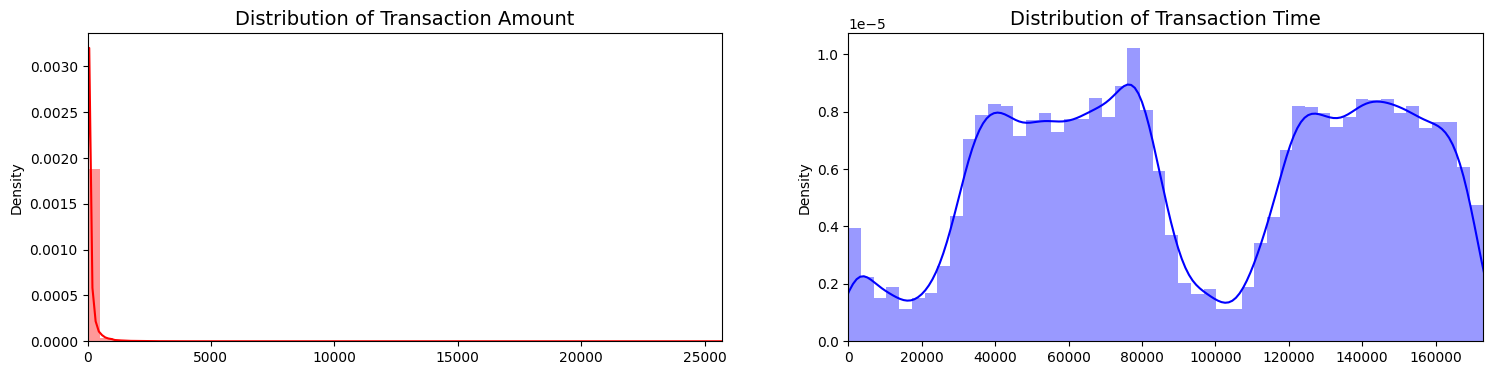

In [4]:
#PLOTTING THE DISTRIBUTION OF TIME AND AMOUNT

fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

<h2> Scaling and Distributing </h2>
<a id="distributing"></a>
We will first scale the columns comprise of <b>Time</b> and <b>Amount </b> as they should be scaled as the other columns. On the other hand, we need to also create a sub sample of the dataframe in order to have an equal amount of Fraud and Non-Fraud cases, helping our algorithms better understand patterns that determines whether a transaction is a fraud or not.

<h3> What is a sub-Sample?</h3>
In this scenario, our subsample will be a dataframe with a 50/50 ratio of fraud and non-fraud transactions. Meaning our sub-sample will have the same amount of fraud and non fraud transactions.

<h3> Why do we create a sub-Sample?</h3>
Using the original dataframe will cause the following issues:
<ul>
<li><b>Overfitting: </b>Our classification models will assume that in most cases there are no frauds! What we want for our model is to be certain when a fraud occurs. </li>
<li><b>Wrong Correlations:</b> Although we don't know what the "V" features stand for, it will be useful to understand how each of this features influence the result (Fraud or No Fraud) by having an imbalance dataframe we are not able to see the true correlations between the class and features. </li>
</ul>

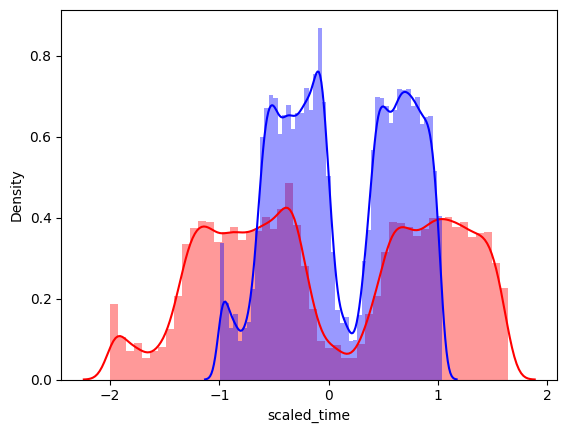

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [5]:
#SCALING THE DATA

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))
df['std_amt'] = std_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['std_tm'] = std_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

sns.distplot(df['std_tm'], color = 'r')
sns.distplot(df['scaled_time'], color = 'b')
plt.show()

scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time','std_amt','std_tm'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

**Standard Scaler:** Scales the data by removing the mean and diving by the standard deviation. The StandardScaler is vulnerable to outliers because outliers affect the mean. The outliers have an influence when computing the empirical mean and standard deviation.
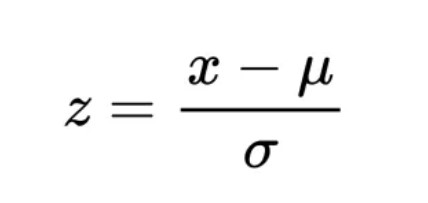


**Robust Scaler:** Scales the data by removing the median and dividing by the interquartile range. It is robust (not sensitive) to outliers as it does not consider them while scaling. Consequently, the resulting range of the transformed feature values is larger than for the standard scaler and, more importantly, are approximately similar.
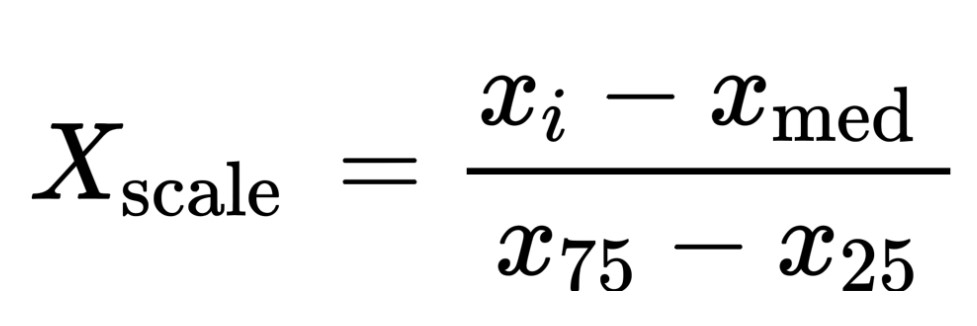

### Splitting the Data (Original DataFrame)
<a id="splitting"></a>
Before proceeding with the <b> Random UnderSampling technique</b> we have to separate the orginal dataframe. Although we are splitting the data when implementing Random UnderSampling or OverSampling techniques, we want to test our models on the original testing set not on the testing set created by either of these techniques.</b> The main goal is to fit the model either with the dataframes that were undersample and oversample (in order for our models to detect the patterns), and test it on the original testing set.

In [6]:
#TRAIN-TEST SPLIT

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
kkk = StratifiedShuffleSplit(n_splits=5, test_size=0.5)
hhh = KFold(n_splits=5)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


**Statified split** Keeps the proportion of training and test sample equal after split. This is not ensured by **Random Sampling**.<br>
**K-Fold** Cross-validation divides the training set into 'k' folds, from which the model trains on 'k-1' folds and validates itself on one fold, 'k' times.<br><br>
**StratifiedKFold** and **StratifiedShuffleSplit** are two methods of stratified sampling in scikit-learn. They differ in the following ways:<br>
**Shuffling:**<br>
StratifiedKFold shuffles the dataset only once, while StratifiedShuffleSplit shuffles the dataset each time before splitting.<br>
**Splitting:**<br>
StratifiedKFold splits the dataset into k folds in a sequential manner, while StratifiedShuffleSplit splits the dataset into k folds in a random manner.<br>
**Test sets:**<br>
StratifiedKFold does not allow test sets to overlap, while StratifiedShuffleSplit allows test sets to overlap.<br>
**Folds:**<br>
StratifiedShuffleSplit returns stratified randomized folds that preserve the percentage of samples for each class.<br>
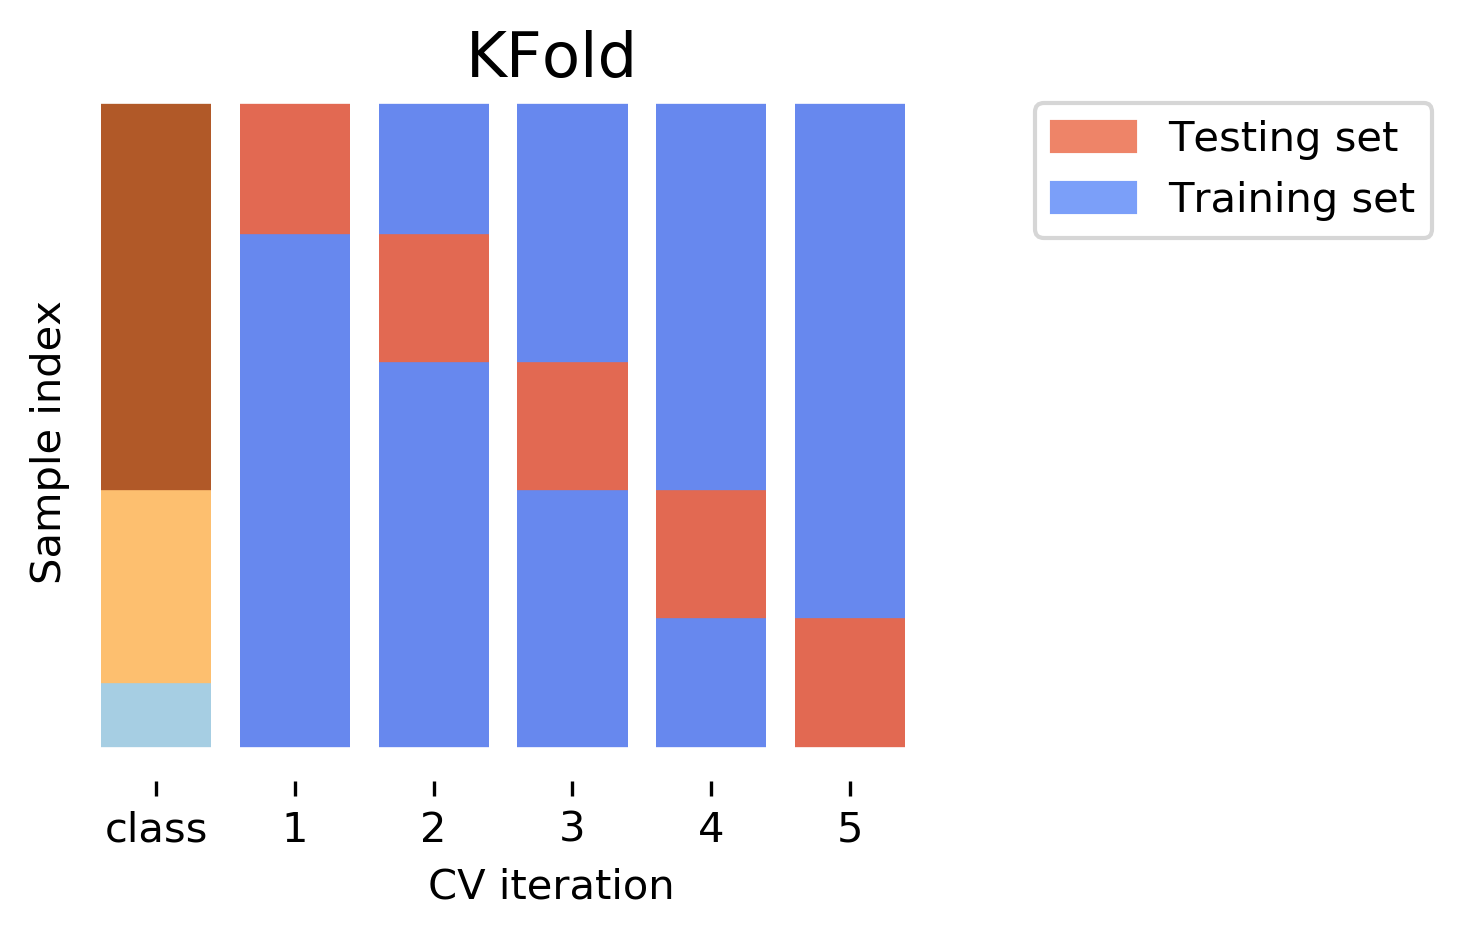
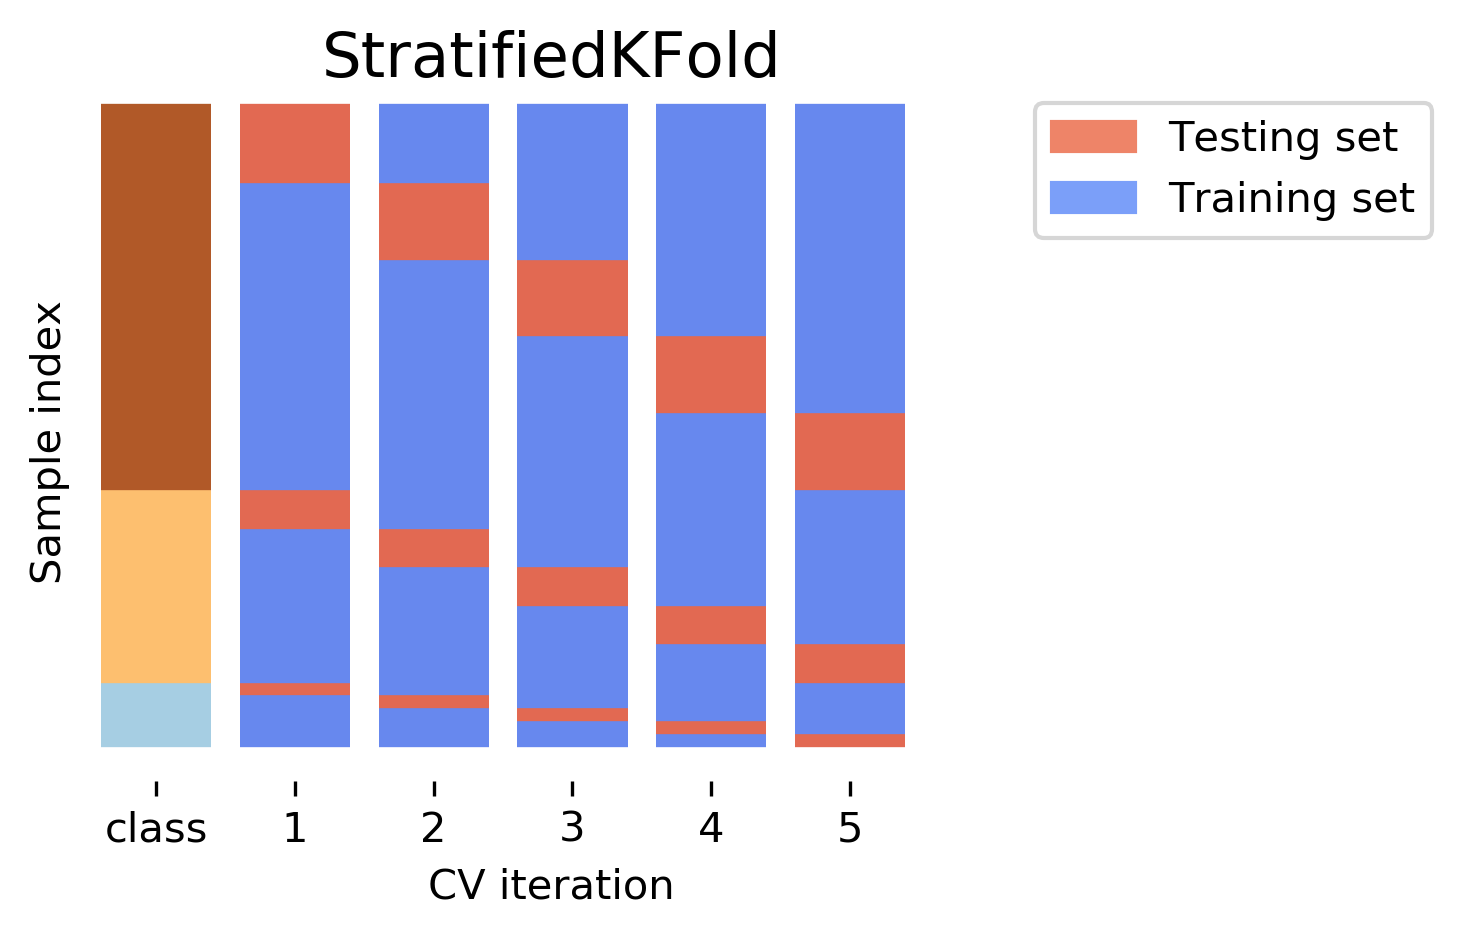

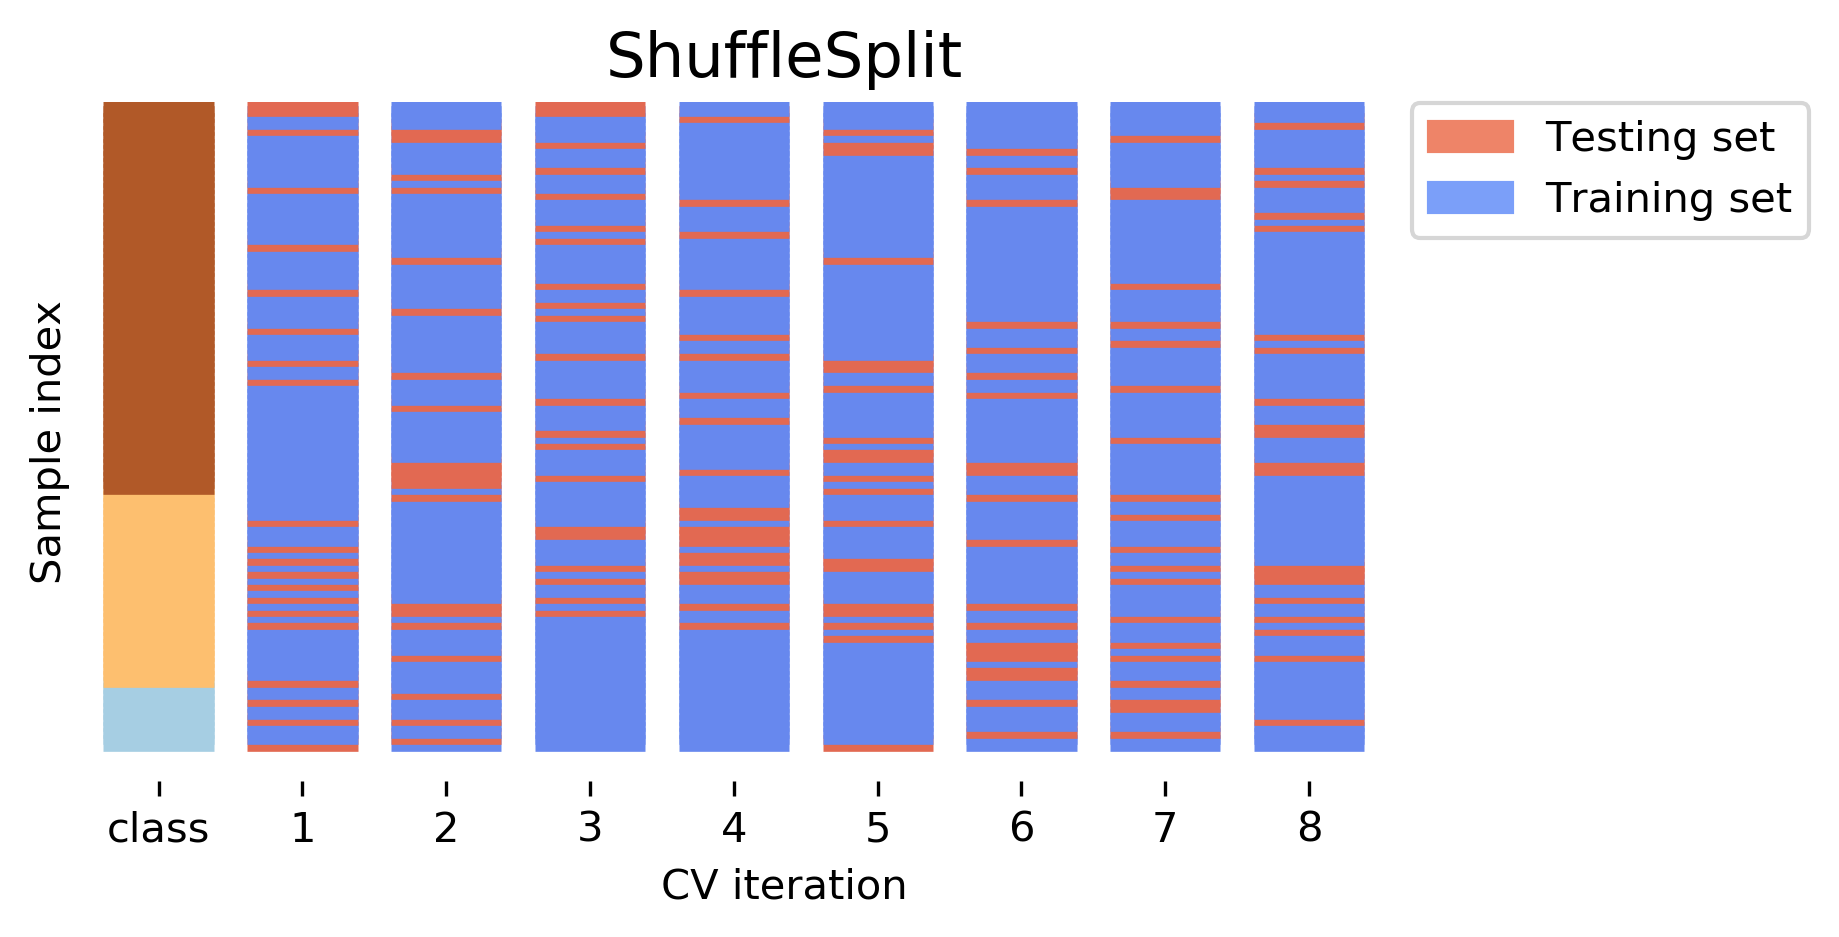
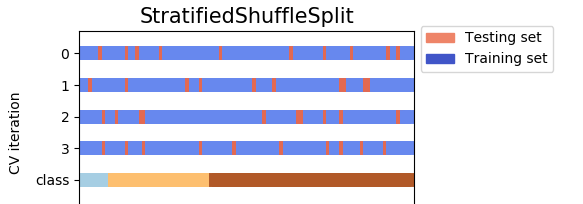

## Random Under-Sampling:

<i>"Random Under Sampling"</i> basically consists of removing data in order to have a more <b> balanced dataset </b> and thus avoiding our models to overfitting.

#### Steps:
<ul>
<li>The first thing we have to do is determine how <b>imbalanced</b> is our class (use "value_counts()" on the class column to determine the amount for each label)  </li>
<li>Once we determine how many instances are considered <b>fraud transactions </b> (Fraud = "1") , we should bring the <b>non-fraud transactions</b> to the same amount as fraud transactions (assuming we want a 50/50 ratio), this will be equivalent to 492 cases of fraud and 492 cases of non-fraud transactions.  </li>
<li> After implementing this technique, we have a sub-sample of our dataframe with a 50/50 ratio with regards to our classes. Then the next step we will implement is to <b>shuffle the data</b> to see if our models can maintain a certain accuracy everytime we run this script.</li>
</ul>

**Note:** The main issue with "Random Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of <b>information loss</b> (bringing 492 non-fraud transaction  from 284,315 non-fraud transaction)

Distribution of the Classes in the subsample dataset
0    0.5
1    0.5
Name: Class, dtype: float64


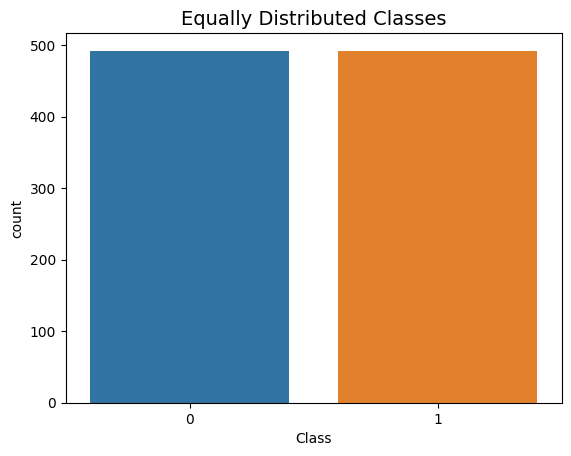

In [7]:
# RANDOM UNDER SAMPLING
# amount of fraud classes 492 rows.

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df[df['Class']==0].sample(n=492)

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))



sns.countplot(data=new_df, x='Class')
plt.title('Equally Distributed Classes', fontsize=14)

plt.show()

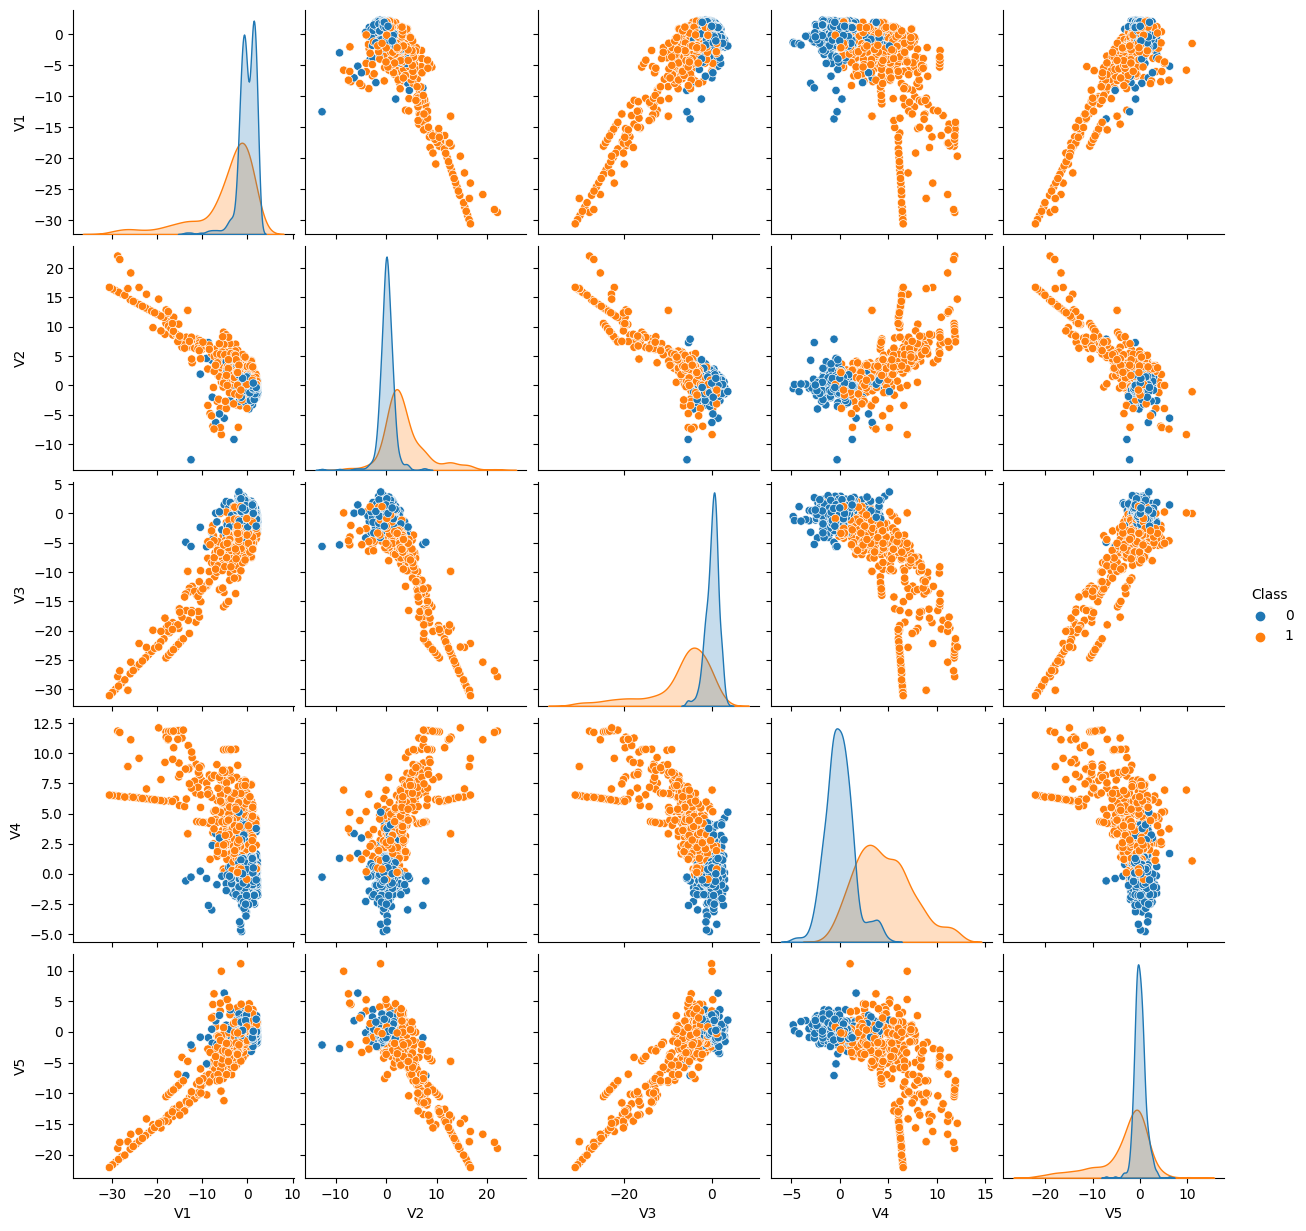

In [8]:
sns.pairplot(new_df[['V1','V2','V3','V4','V5','Class']],hue='Class')

<h3> Correlation Matrices </h3>
Correlation matrices are the essence of understanding our data. We want to know if there are features that influence heavily in whether a specific transaction is a fraud. However, it is important that we use the correct dataframe (subsample)  in order for us to see which features have a high positive or negative correlation with regards to fraud transactions.

**Note:** We have to make sure we use the subsample in our correlation matrix or else our correlation matrix will be affected by the high imbalance between our classes. This occurs due to the high class imbalance in the original dataframe.

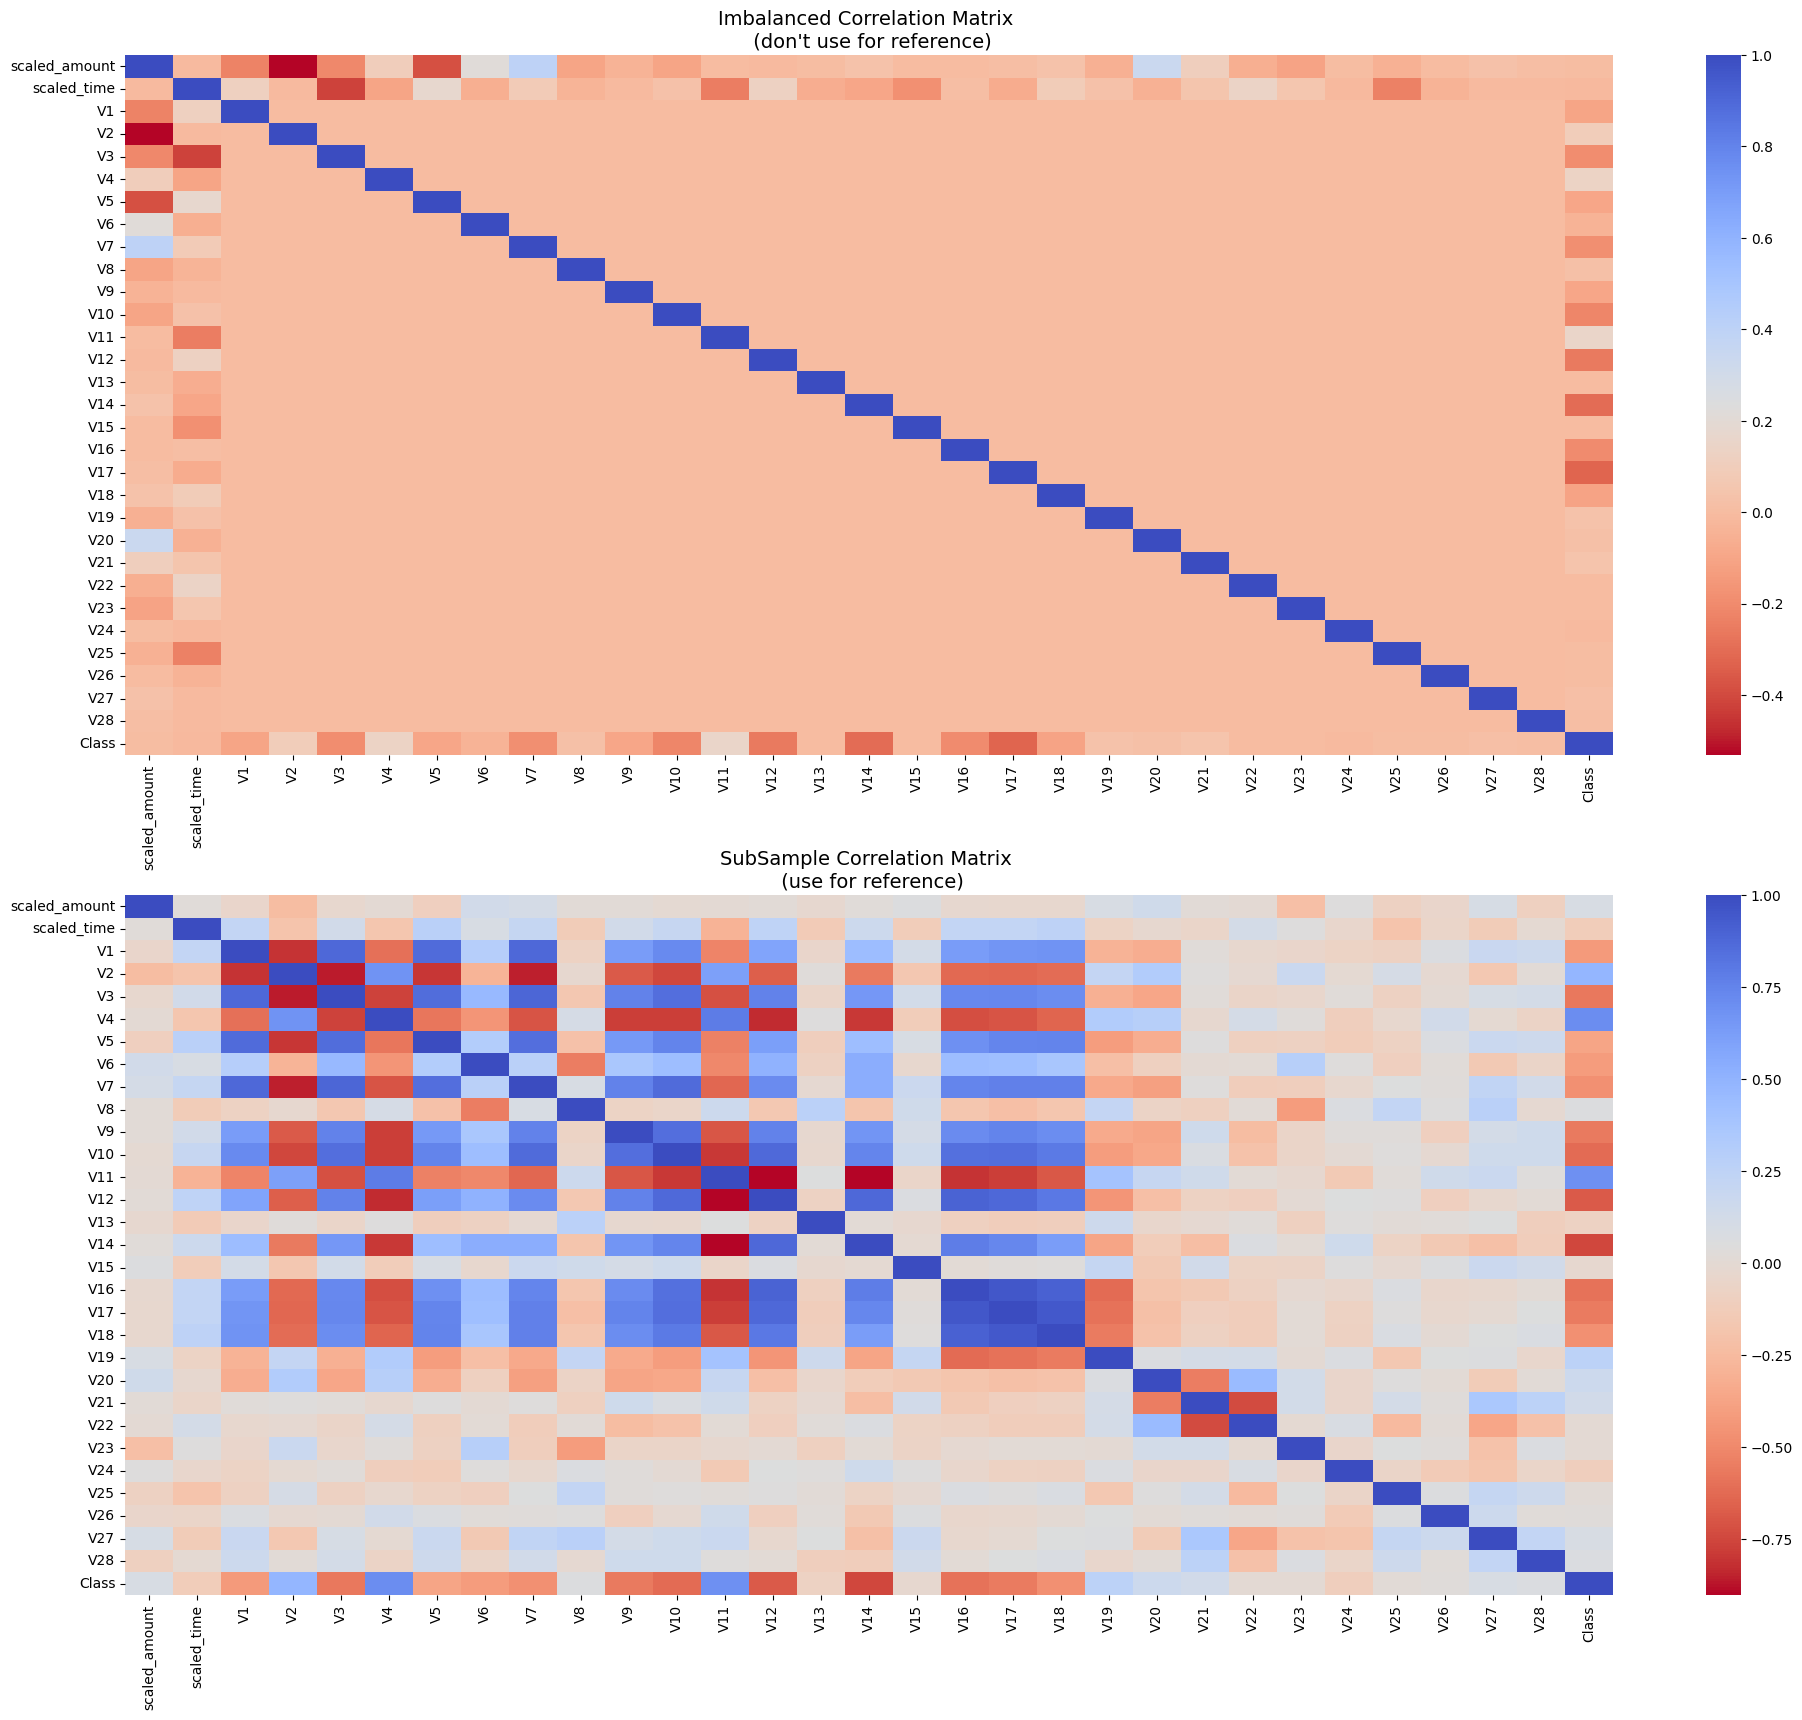

In [9]:
# CORRELATION MATRIX

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

# subsample
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

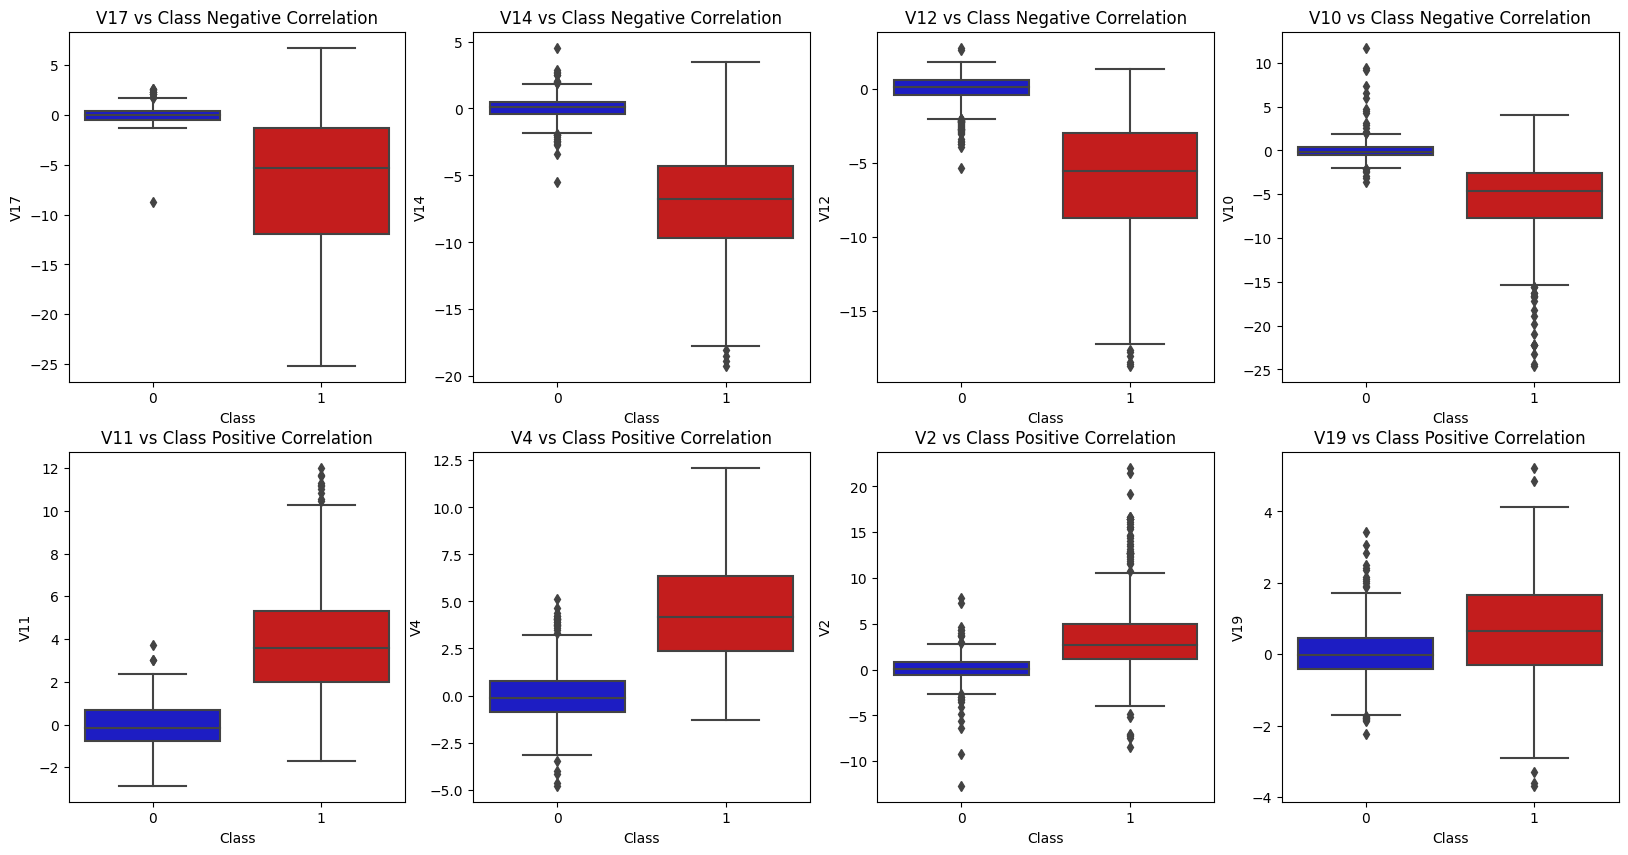

In [10]:
colors = ["#0101DF", "#DF0101"]


f, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,10))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0,0])
axes[0,0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[0,1])
axes[0,1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[0,2])
axes[0,2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[0,3])
axes[0,3].set_title('V10 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[1,0])
axes[1,0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1,1])
axes[1,1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[1,2])
axes[1,2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[1,3])
axes[1,3].set_title('V19 vs Class Positive Correlation')

plt.show()

### Summary and Explanation:
<ul>
<li><b>Negative Correlations: </b>V17, V14, V12 and V10 are negatively correlated. <i>Notice how the lower these values are, the more likely the end result will be a fraud transaction.</i>  </li>
<li> <b> Positive Correlations: </b> V2, V4, V11, and V19 are positively correlated. <i>Notice how the higher these values are, the more likely the end result will be a fraud transaction.</i> </li>
<li> <b>BoxPlots: </b>  We have used boxplots to have a better understanding of the distribution of these features in fradulent and non fradulent transactions. </li>
</ul>

## Anomaly Detection:
<a id="anomaly"></a>


Our main aim in this section is to remove "extreme outliers" from features that have a high correlation with our classes. This will have a positive impact on the accuracy of our models.  <br><br>


### Interquartile Range Method:
<ul>
<li> <b>Interquartile Range (IQR): </b> We calculate this by the difference between the 75th percentile and 25th percentile. Our aim is to create a threshold beyond the 75th and 25th percentile that in case some instance pass this threshold the instance will be deleted.  </li>
<li> <b>Boxplots: </b> Besides easily seeing the 25th and 75th percentiles (both end of the squares) it is also easy to see extreme outliers (points beyond the lower and higher extreme). </li>
</ul>

### Outlier Removal Tradeoff:
We have to be careful as to how far do we want the threshold for removing outliers. We determine the threshold by multiplying a number (ex: 1.5) by the (Interquartile Range). The higher this threshold is, the less outliers will detect (multiplying by a higher number ex: 3), and the lower this threshold is the more outliers it will detect.  <br><br>

<b>The Tradeoff: </b>
The lower the threshold the more outliers it will remove however, we want to focus more on "extreme outliers" rather than just outliers because we might run the risk of information loss which will cause our models to have a lower accuracy.


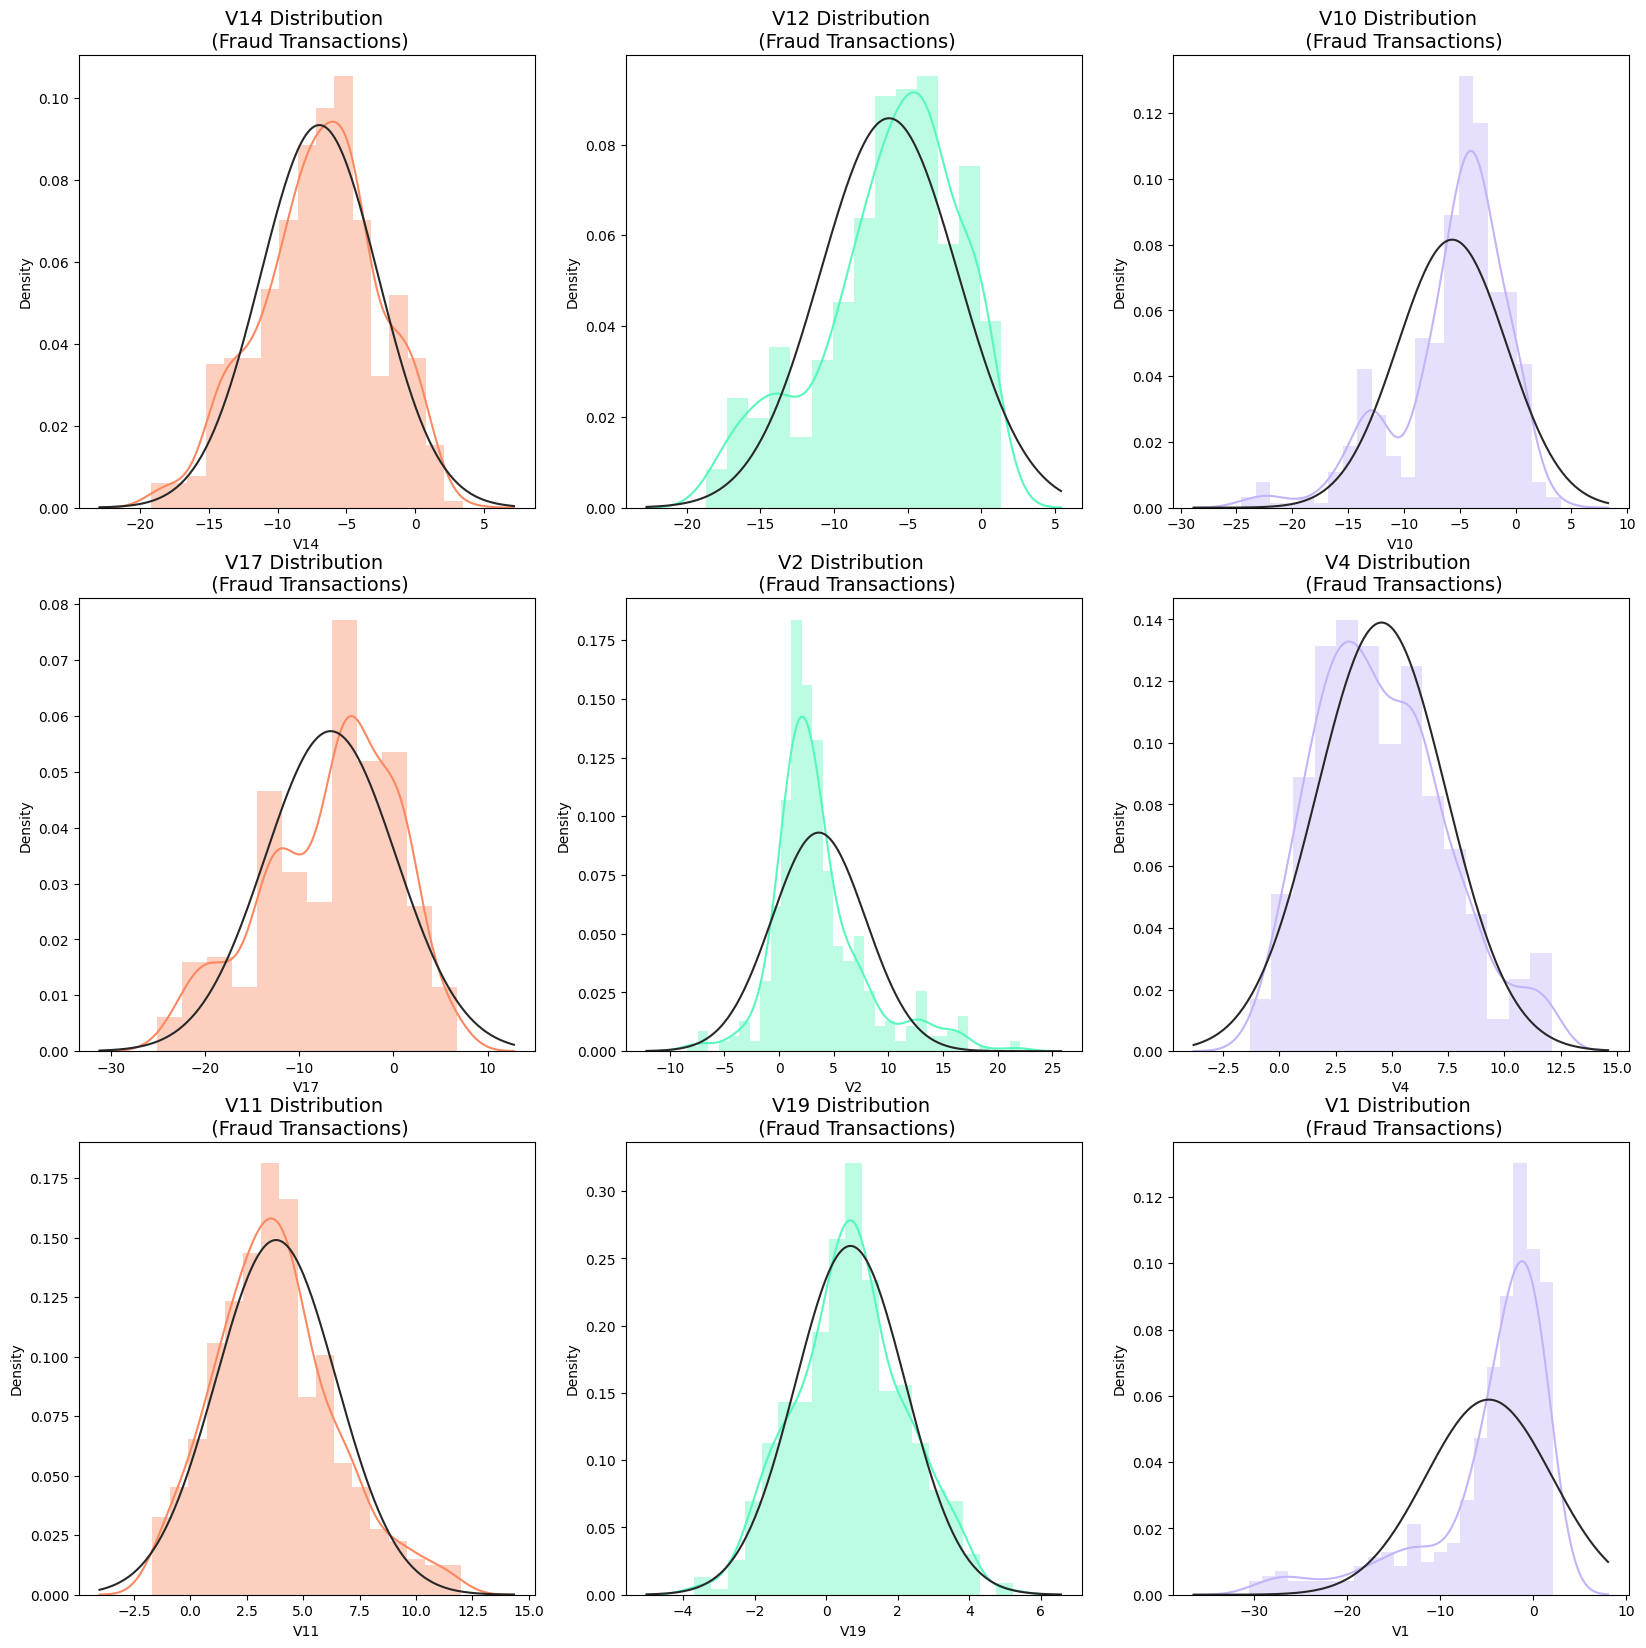

In [11]:
from scipy.stats import norm

f, ax = plt.subplots(3,3, figsize=(20, 20))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1]
sns.distplot(v14_fraud_dist,ax=ax[0,0], fit=norm, color='#FB8861')
ax[0,0].set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax[0,1], fit=norm, color='#56F9BB')
ax[0,1].set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1]
sns.distplot(v10_fraud_dist,ax=ax[0,2], fit=norm, color='#C5B3F9')
ax[0,2].set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

v17_fraud_dist = new_df['V17'].loc[new_df['Class'] == 1]
sns.distplot(v17_fraud_dist,ax=ax[1,0], fit=norm, color='#FB8861')
ax[1,0].set_title('V17 Distribution \n (Fraud Transactions)', fontsize=14)

v2_fraud_dist = new_df['V2'].loc[new_df['Class'] == 1]
sns.distplot(v2_fraud_dist,ax=ax[1,1], fit=norm, color='#56F9BB')
ax[1,1].set_title('V2 Distribution \n (Fraud Transactions)', fontsize=14)


v4_fraud_dist = new_df['V4'].loc[new_df['Class'] == 1]
sns.distplot(v4_fraud_dist,ax=ax[1,2], fit=norm, color='#C5B3F9')
ax[1,2].set_title('V4 Distribution \n (Fraud Transactions)', fontsize=14)

v11_fraud_dist = new_df['V11'].loc[new_df['Class'] == 1]
sns.distplot(v11_fraud_dist,ax=ax[2,0], fit=norm, color='#FB8861')
ax[2,0].set_title('V11 Distribution \n (Fraud Transactions)', fontsize=14)

v19_fraud_dist = new_df['V19'].loc[new_df['Class'] == 1]
sns.distplot(v19_fraud_dist,ax=ax[2,1], fit=norm, color='#56F9BB')
ax[2,1].set_title('V19 Distribution \n (Fraud Transactions)', fontsize=14)


v1_fraud_dist = new_df['V1'].loc[new_df['Class'] == 1]
sns.distplot(v1_fraud_dist,ax=ax[2,2], fit=norm, color='#C5B3F9')
ax[2,2].set_title('V1 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [12]:
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)


v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


v19_fraud = new_df['V19'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v19_fraud, 25), np.percentile(v19_fraud, 75)
v19_iqr = q75 - q25

v19_cut_off = v19_iqr * 1.5
v19_lower, v19_upper = q25 - v19_cut_off, q75 + v19_cut_off
print('V19 Lower: {}'.format(v19_lower))
print('V19 Upper: {}'.format(v19_upper))
outliers = [x for x in v19_fraud if x < v19_lower or x > v19_upper]
print('V19 outliers: {}'.format(outliers))
print('Feature V19 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V19'] > v19_upper) | (new_df['V19'] < v19_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


v4_fraud = new_df['V4'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v4_fraud, 25), np.percentile(v4_fraud, 75)
v4_iqr = q75 - q25

v4_cut_off = v4_iqr * 1.5
v4_lower, v4_upper = q25 - v4_cut_off, q75 + v4_cut_off
print('V4 Lower: {}'.format(v4_lower))
print('V4 Upper: {}'.format(v4_upper))
outliers = [x for x in v4_fraud if x < v4_lower or x > v4_upper]
print('V4 outliers: {}'.format(outliers))
print('Feature V4 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V4'] > v4_upper) | (new_df['V4'] < v4_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))


Quartile 25: -9.692722964972386 | Quartile 75: -4.282820849486865
iqr: 5.409902115485521
Cut Off: 8.114853173228282
V14 Lower: -17.807576138200666
V14 Upper: 3.8320323237414167
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-18.4937733551053, -19.2143254902614, -18.8220867423816, -18.0499976898594]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.6837146333443, -18.4311310279993, -18.0475965708216, -18.5536970096458]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 975
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.92033495834214
V10 outliers: [-18.2711681738888, -24.588262

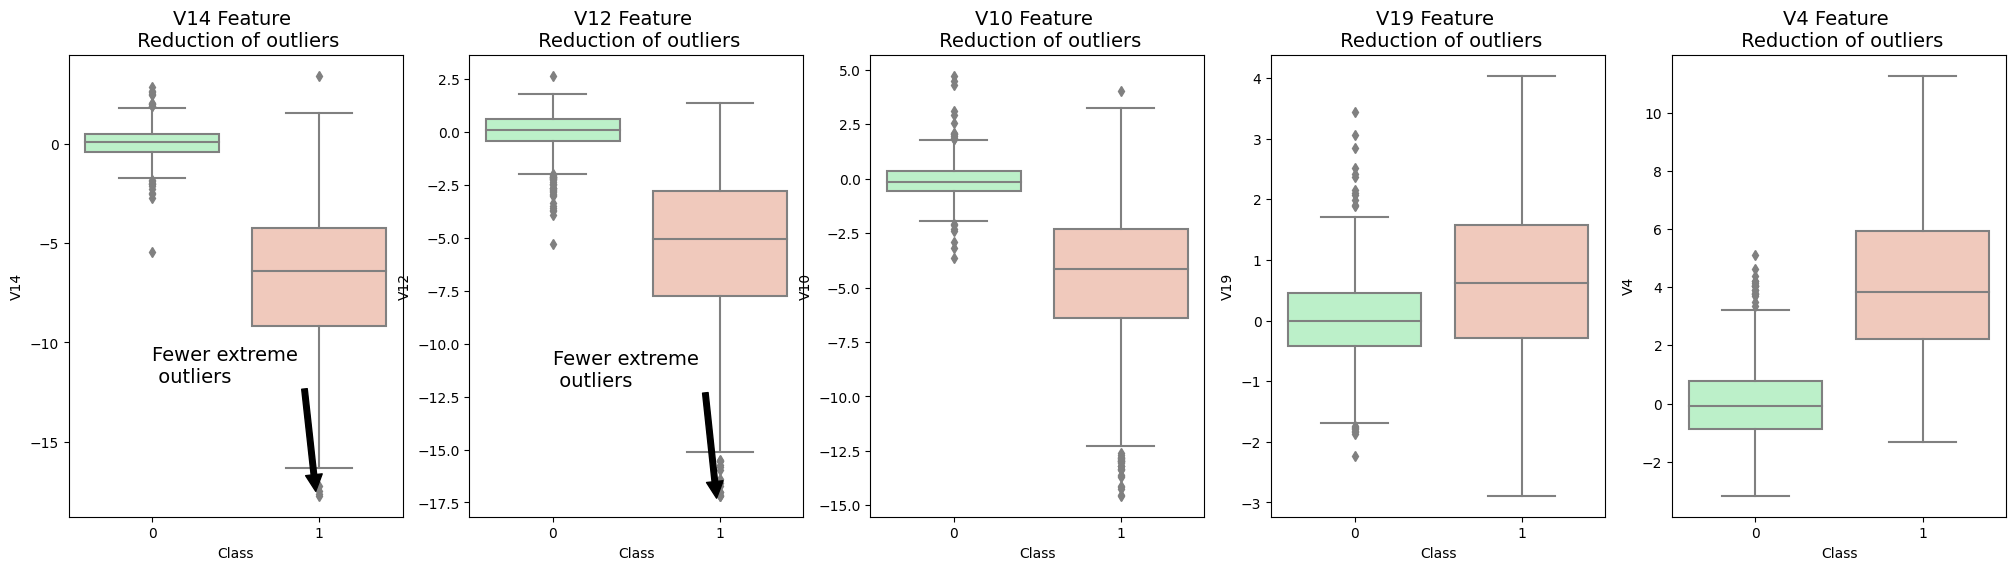

In [13]:
f,(ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V19
sns.boxplot(x="Class", y="V19", data=new_df, ax=ax4, palette=colors)
ax4.set_title("V19 Feature \n Reduction of outliers", fontsize=14)
ax4.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V4
sns.boxplot(x="Class", y="V4", data=new_df, ax=ax5, palette=colors)
ax5.set_title("V4 Feature \n Reduction of outliers", fontsize=14)
ax5.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)
plt.show()


### Summary:
<ul>
<li> <b> Visualize Distributions: </b> We started by visualizing the distribution of the feature we are going to use to eliminate some of the outliers. V14 is the only feature that has a Gaussian distribution compared to features V12 and V10. </li>
<li><b>Determining the threshold: </b> After we decide which number we will use to multiply with the iqr (the lower more outliers removed), we will proceed in determining the upper and lower thresholds by substrating q25 - threshold (lower extreme threshold) and adding q75 + threshold (upper extreme threshold). </li>
<li> <b>Conditional Dropping: </b> Lastly, we create a conditional dropping stating that if the "threshold" is exceeded in both extremes, the instances will be removed. </li>
<li> <b> Boxplot Representation: </b> Visualize through the boxplot that the number of "extreme outliers" have been reduced to a considerable amount. </li>
</ul>

**Note:** After implementing outlier reduction our accuracy has been improved by over 3%! Some outliers can distort the accuracy of our models but remember, we have to avoid an extreme amount of information loss or else our model runs the risk of underfitting.

<h2>Dimensionality Reduction and Clustering: </h2>
<a id="clustering"></a>

<h3>Understanding t-SNE:  </h3>
t-SNE (t-distributed Stochastic Neighbor Embedding) is an unsupervised non-linear dimensionality reduction technique for data exploration and visualizing high-dimensional data. Non-linear dimensionality reduction means that the algorithm allows us to separate data that cannot be separated by a straight line.  <br>
<ul>
<li> <b>Determine the similarity between all the points in the data. </b> To do this, take any point in random and make it the centre of a normal distribution and measure the likelihood of all the other points belonging to this distribution. Naturally, points closer to this point will have a higher likelihood than points farther to the point. </li>
<li> <b>Scale the likelihoods to sum up to one.</b> We do this because we may have clusters that are less dense than others (higher standard deviation), and to make the likelihood same across all clusters, we need to normalise them. The scaled similarity scores for a relatively tight cluster should be the same as that of a relatively wide cluster.</li>
<li><b>Matrix of similarty scores.</b> Averaging the similarity on all direction will give us a marix of all the similarity among all the points.   </li>
<li><b>t-distributed similarity.</b> Arrange all the points in the data onto a linear line and repeat calculating the similarity, except this time use a t-distribution to calculate the likelihood. We get another matrix of similarity. t-SNE will use a step by step stochastic process, to move the data points around, till the point that the t-distributed matrix ends up closely similar to the normal similarity matrix.      </li>
</ul>



In [14]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

T-SNE took 8.4 s
PCA took 0.017 s


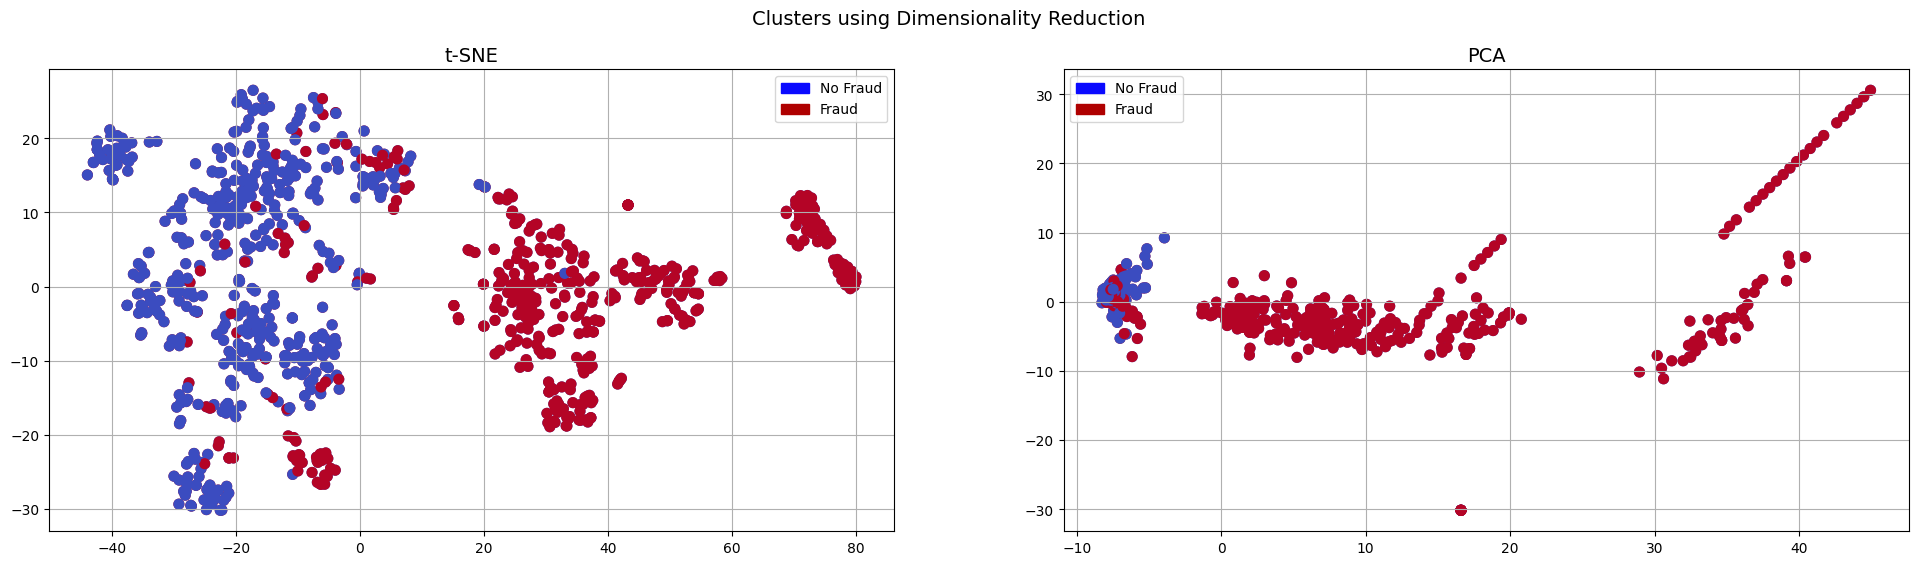

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2 , figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

plt.show()

<h3> Summary: </h3>
<ul>
<li>t-SNE algorithm can pretty accurately cluster the cases that were fraud and non-fraud in our dataset. </li>
<li> Although the subsample is pretty small, the t-SNE algorithm is able to detect clusters pretty accurately in every scenario (I shuffle the dataset before running t-SNE)</li>
<li> This gives us an indication that further predictive models will perform pretty well in separating fraud cases from non-fraud cases. </li>
</ul>

<h2> Classifiers (UnderSampling):  </h2>
<a id="classifiers"></a>
In this section we will train four types of classifiers and decide which classifier will be more effective in detecting <b>fraud transactions</b>.  Before that, we have to split our data into training and testing sets.


In [16]:
# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [17]:
# simple baseline classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [18]:
# Cross-Validated scores
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 94.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 93.0 % accuracy score
Classifiers:  SVC Has a training score of 93.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 91.0 % accuracy score


In [21]:
# Grid Search

# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_
print(grid_log_reg.best_params_)

#KNN
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_
print(grid_knears.best_params_)

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
# SVC best estimator
svc = grid_svc.best_estimator_
print(grid_svc.best_params_)

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)),
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)
# tree best estimator
tree_clf = grid_tree.best_estimator_
print(grid_tree.best_params_)

{'C': 0.1, 'penalty': 'l2'}
{'algorithm': 'auto', 'n_neighbors': 2}
{'C': 0.5, 'kernel': 'rbf'}
{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 5}


In [22]:
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  93.77%
Knears Neighbors Cross Validation Score 92.69%
Support Vector Classifier Cross Validation Score 93.77%
DecisionTree Classifier Cross Validation Score 92.15%


<h3> NearMiss Undersampling:</h3>

Near Miss refers to a collection of undersampling methods that select examples based on the distance of majority class examples to minority class examples.

The approaches were proposed by Jianping Zhang and Inderjeet Mani in their 2003 paper titled “KNN Approach to Unbalanced Data Distributions: A Case Study Involving Information Extraction.”

There are three versions of the technique, named NearMiss-1, NearMiss-2, and NearMiss-3.

NearMiss-1 selects examples from the majority class that have the smallest average distance to the three closest examples from the minority class. NearMiss-2 selects examples from the majority class that have the smallest average distance to the three furthest examples from the minority class. NearMiss-3 involves selecting a given number of majority class examples for each example in the minority class that are closest.

Here, distance is determined in feature space using Euclidean distance or similar.

NearMiss-1: Majority class examples with minimum average distance to three closest minority class examples.
NearMiss-2: Majority class examples with minimum average distance to three furthest minority class examples.
NearMiss-3: Majority class examples with minimum distance to each minority class example.

In [23]:
# We will undersample during cross validating
from imblearn.under_sampling import NearMiss
from collections import Counter
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report



undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]

undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])

    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
NearMiss Label Distribution: Counter({0: 492, 1: 492})


In [24]:
# Let's Plot LogisticRegression Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")

    # Second Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")

    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")

    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

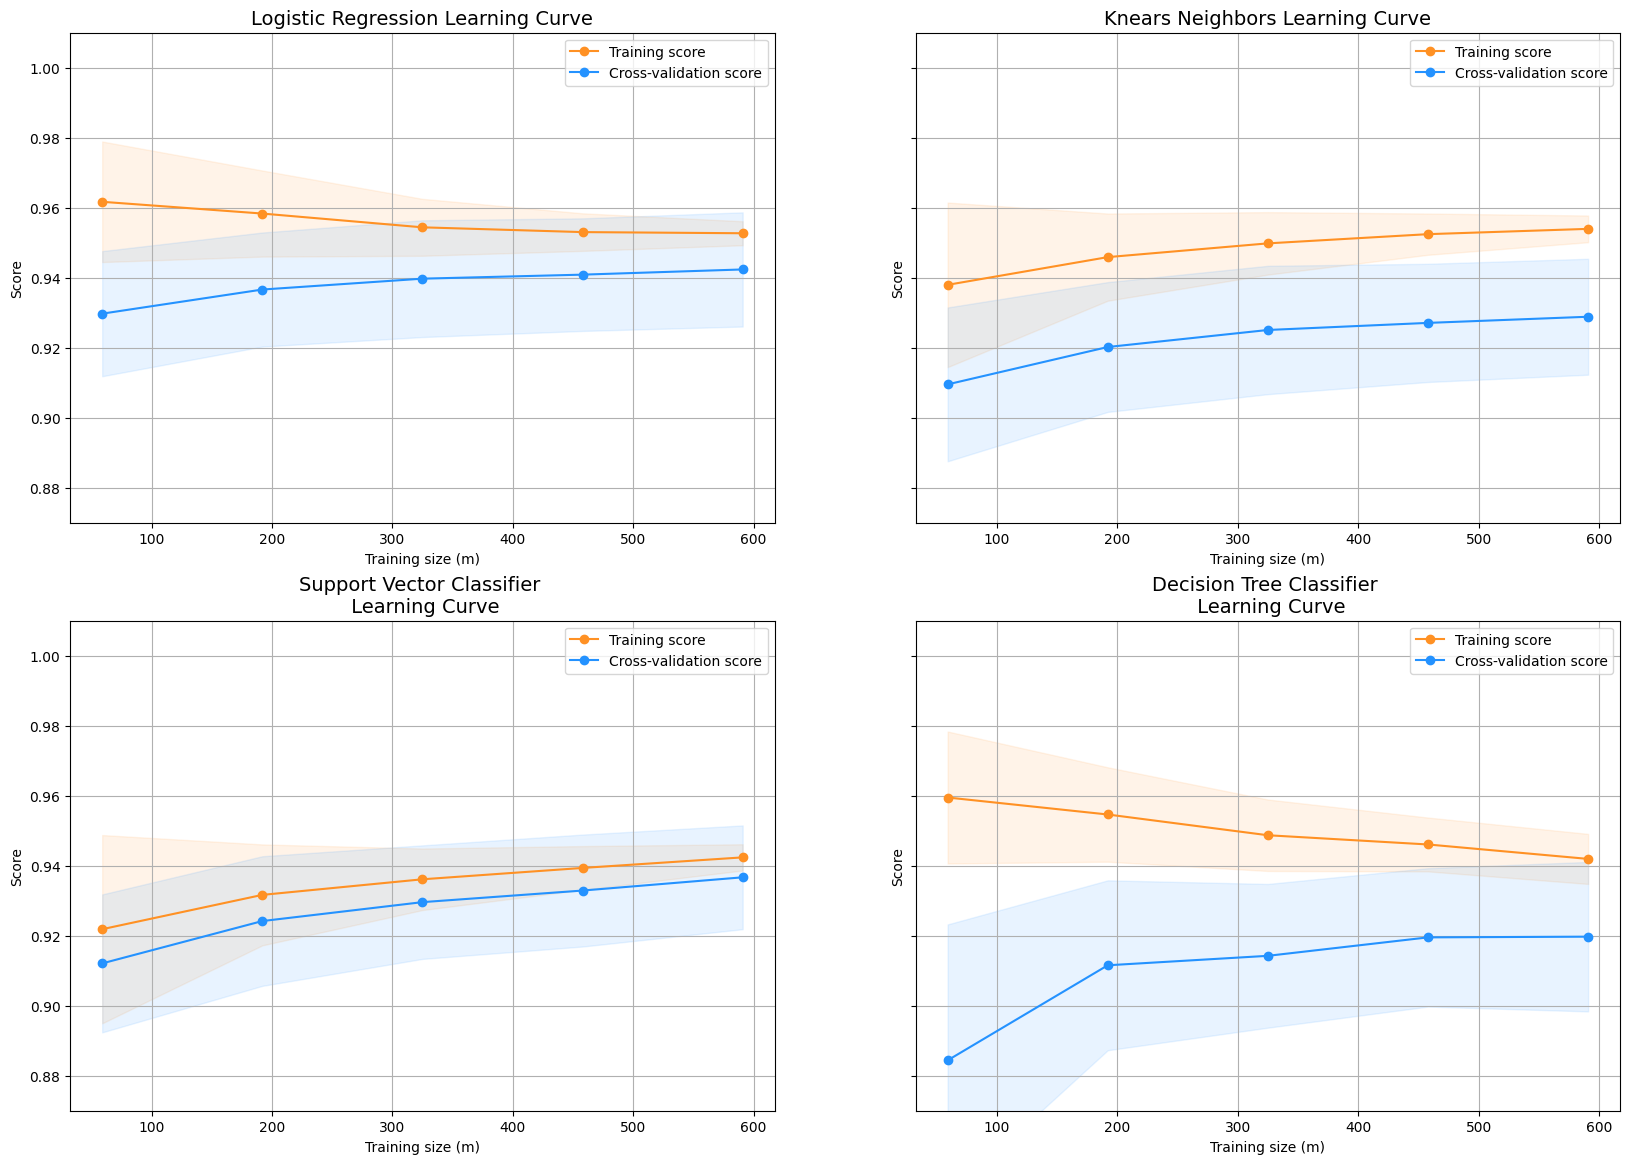

In [25]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [26]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [27]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9777055990101198
KNears Neighbors:  0.9222678863405365
Support Vector Classifier:  0.980489637191215
Decision Tree Classifier:  0.9192555275678701


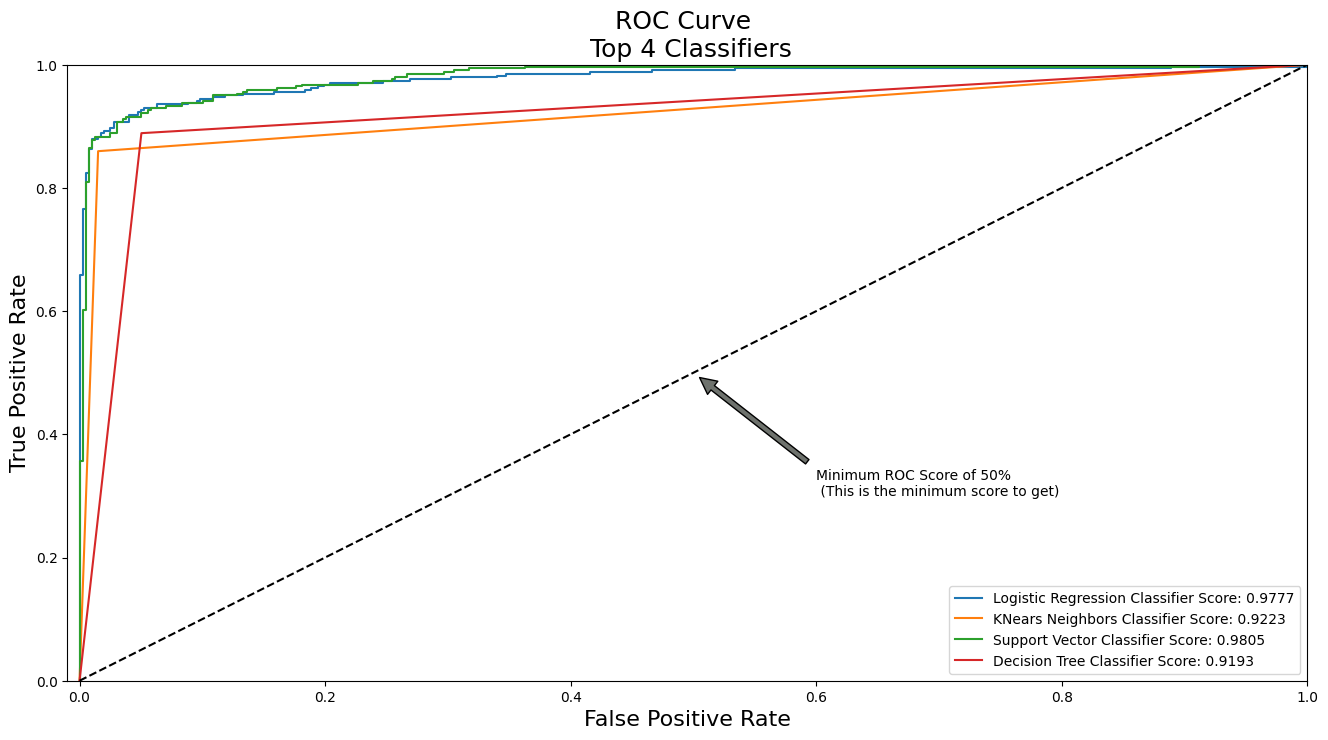

In [28]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()

graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

## Summary:
<ul>
<li> <b> Logistic Regression </b> classifier is more accurate than the other three classifiers in most cases. (We will further analyze Logistic Regression) </li>
<li><b> GridSearchCV </b> is used to determine the paremeters that gives the best predictive score for the classifiers. </li>
<li> Logistic Regression has the best Receiving Operating Characteristic score  (ROC), meaning that LogisticRegression pretty accurately separates <b> fraud </b> and <b> non-fraud </b> transactions.</li>
</ul>

## Learning Curves:
<ul>
<li>The <b>wider the  gap</b>  between the training score and the cross validation score, the more likely your model is <b>overfitting (high variance)</b>.</li>
<li> If the score is low in both training and cross-validation sets</b> this is an indication that our model is <b>underfitting (high bias)</b></li>
<li><b> Logistic Regression Classifier</b>  shows the best score in both training and cross-validating sets.</li>
</ul>

### SMOTE Technique (Over-Sampling):
<a id="smote"></a>

<b>SMOTE</b> stands for Synthetic Minority Over-sampling Technique.  Unlike Random UnderSampling, SMOTE creates new synthetic points in order to have an equal balance of the classes. This is another alternative for solving the "class imbalance problems". <br><br>


<b> Understanding SMOTE: </b>
<ul>
<li> <b> Solving the Class Imbalance: </b> SMOTE creates synthetic points from the minority class in order to reach an equal balance between the minority and majority class. </li>
<li><b>Location of the synthetic points: </b>   SMOTE picks the distance between the closest neighbors of the minority class, in between these distances it creates synthetic points. </li>
<li> <b>Final Effect:  </b> More information is retained since we didn't have to delete any rows unlike in random undersampling.</li>
<li><b> Accuracy & Time Tradeoff: </b> Although it is likely that SMOTE will be more accurate than random under-sampling, it will take more time to train since no rows are eliminated as previously stated.</li>

</ul>

### Cross Validation Overfitting Mistake:
## Overfitting during Cross Validation:  
One should always undersample or oversample the data before cross validating because you will be directly influencing the validation set before implementing cross-validation causing a "data leakage" problem. <b>The model should not be tested or validated on synthetic data</b><br><br> <b>In the following section you will see amazing precision and recall scores but in reality our data is overfitting!</b>
### The Wrong Way:
<img src="https://www.marcoaltini.com/uploads/1/3/2/3/13234002/2639934.jpg?401"><br>

As mentioned previously, if we get the minority class ("Fraud) in our case, and create the synthetic points before cross validating we have a certain influence on the "validation set" of the cross validation process. Remember how cross validation works, let's assume we are splitting the data into 5 batches, 4/5 of the dataset will be the training set while 1/5 will be the validation set. The test set should not be touched! For that reason, we have to do the creation of synthetic datapoints "during" cross-validation and not before, just like below: <br>


### The Right Way:
<img src="https://www.marcoaltini.com/uploads/1/3/2/3/13234002/9101820.jpg?372"> <br>
As you see above, SMOTE occurs "during" cross validation and not "prior" to the cross validation process. Synthetic data are created only for the training set without affecting the validation set.



In [29]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()




rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


# Implementing SMOTE Technique
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])

    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))

print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 227846 | Length of y (train): 227846
Length of X (test): 56961 | Length of y (test): 56961


ValueError: ignored

In [ ]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

In [ ]:
y_score = best_est.decision_function(original_Xtest)

In [ ]:
from sklearn.metrics import average_precision_score, precision_recall_curve
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

In [ ]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [ ]:
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to
Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

# Test Data with Logistic Regression:
<a id="testing_logistic"></a>
## Confusion Matrix:
**Positive/Negative:** Type of Class (label) ["No", "Yes"]
**True/False:** Correctly or Incorrectly classified by the model.<br><br>

**True Negatives (Top-Left Square):** This is the number of **correctly** classifications of the "No" (No Fraud Detected) class. <br><br>

**False Negatives (Top-Right Square):** This is the number of **incorrectly** classifications of the "No"(No Fraud Detected) class. <br><br>

**False Positives (Bottom-Left Square):** This is the number of **incorrectly** classifications of the "Yes" (Fraud Detected) class <br><br>

**True Positives (Bottom-Right Square):** This is the number of **correctly** classifications of the "Yes" (Fraud Detected) class.


### Summary:
<ul>
<li> <b>Random UnderSampling:</b> We will evaluate the final performance of the classification models in the random undersampling subset. <b>Keep in mind that this is not the data from the original dataframe. </b> </li>
<li> <b>Classification Models: </b> The models that performed the best were <b>logistic regression </b> and <b>support vector classifier (SVM)</b>  </li>
</ul>

In [ ]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

In [ ]:
from sklearn.metrics import classification_report


print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_tree))

In [ ]:
# Final Score in the test set of logistic regression
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)



# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)


d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

# Note how high is accuracy score it can be misleading!
final_df